# Intel AI Kit and XGBoost

### Learning objectives

* Utilize XGBoost with Intel's AI KIt
* Take advantage of Intel extensions to SciKit Learn by enabling them with XGBoost
* Use Cross Validation technique to find better XGBoost Hyperparameters
* Use a learning curve to estimate the ideal number of trees
* Improve performance by implementing early stopping


In this example, we will use a dataset with particle features and functions of those features **to distinguish between a signal process which produces Higgs bosons (1) and a background process which does not (0)**. The Higgs boson is a basic particle in the standard model produced by the quantum excitation of the Higgs field, named after physicist Peter Higgs.

![image](3D_view_energy_of_8_TeV.png)
[Images Source](https://commons.wikimedia.org/wiki/File:3D_view_of_an_event_recorded_with_the_CMS_detector_in_2012_at_a_proton-proton_centre_of_mass_energy_of_8_TeV.png)

## Import Necessary Libraries

In [26]:
%pip install scikit-learn
%pip install xgboost
%pip install pandas
%pip install numpy
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip 

In [27]:
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int16Dtype  # if you don't import in this order you will get a pandas.Int64Index fix for FutureWarning error.
from time import perf_counter
import matplotlib.pyplot as plt

# This line is a Jupyter Notebook magic command that allows plots to be displayed inline
%matplotlib inline

print("XGB Version          : ", xgb.__version__)
print("Scikit-Learn Version : ", sklearn.__version__)
print("Pandas Version       : ", pd.__version__)


XGB Version          :  2.0.2
Scikit-Learn Version :  1.3.2
Pandas Version       :  2.1.3


## Import the Data:

* The first column is the class label (1 for signal, 0 for background), followed by the 28 features (21 low-level features then 7 high-level features):

* The dataset has 1.1 million rows, adjust the __nrows__ value to something manageable by the sytem you happen to be using.  100K is easy for a modern laptop; however, once you start optimizing much more than that can take some time. 

[Data Source](https://archive.ics.uci.edu/ml/datasets/HIGGS)

### To get the data using the Intel DevCloud execute the following cells:

In [8]:
!wget -O higgs.zip https://archive.ics.uci.edu/static/public/280/higgs.zip

--2023-11-29 21:27:26--  https://archive.ics.uci.edu/static/public/280/higgs.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘filename.extension’

filename.extension      [     <=>            ]   2.62G  99.6MB/s    in 30s     

2023-11-29 21:27:56 (88.8 MB/s) - ‘filename.extension’ saved [2816865137]



In [7]:
# ! cp /data/oneapi_workshop/big_datasets/xgboost/HIGGS.tar.gz .

cp: cannot stat '/data/oneapi_workshop/big_datasets/xgboost/HIGGS.tar.gz': No such file or directory


In [9]:
# ! tar -xzf HIGGS.tar.gz
! unzip higgs.zip

Archive:  higgs.zip
  inflating: HIGGS.csv.gz            


In [11]:
import pandas as pd
import gzip
import shutil

# Specify the input and output file names
input_file = "HIGGS.csv.gz"
output_file = "HIGGS.csv"

# Decompress the gzip file
with gzip.open(input_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Load the data into a DataFrame
df = pd.read_csv(output_file)

# Display the first few rows of the DataFrame
df.head()


,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,...,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818


### __Do not__ run this if on the Intel DevCloud.  To fetch the data for your local install execute the below two cells.

In [ ]:
# import os
# import requests
# if not os.path.isfile("./HIGGS.csv.gz"):
#         print("Fetching data set from Internet...~2.8GB")
#         url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz"
#         myfile = requests.get(url)
#         with open('./HIGGS.csv.gz', 'wb') as f:
#             f.write(myfile.content)

In [ ]:
# ! gunzip HIGGS.csv.gz

### Set the number of rows to use via nrows= variable.  100K is manageable on a laptop.

In [12]:
filename = 'HIGGS.csv'
names =  ['class_label', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
#data = pd.read_csv(filename, names=names, delimiter=",", nrows=100000)
data = pd.read_csv(filename, names=names, delimiter=",", nrows=1100000)
print(data.shape)

(1100000, 29)


In [ ]:
%time p_df = pd.read_csv("HIGGS.csv")

### Examine the data:

In [13]:
data.head()

,class_label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


* What kind of data is this?

In [14]:
data.dtypes

class_label                 float64
lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

* Examine the distribution of the Higgs Boson class_label.  Depending on how many rows you load this could change how you choose to split the data.  

In [15]:
data.class_label.value_counts()

class_label
1.0    582469
0.0    517531
Name: count, dtype: int64

* In this scenario loading 100000 rows the balance isn't too skewed, the next cell is optional.

In [16]:
data.class_label.value_counts(normalize=True)

class_label
1.0    0.529517
0.0    0.470483
Name: proportion, dtype: float64

### Create your train/test split. 

* Remember the first column is 0 = no signal 1 = signal, so we want to leave out the labels and predict column 0.  

In [17]:
X, y = data.iloc[:, 1:],data.iloc[:,0]

* These next two cell are optional, just a sanity check of the split data actually representing our intentions.

In [18]:
#check split of data.  This is the x variable.
print(data.iloc[:,1:])

         lepton pT  lepton eta  lepton phi  missing energy magnitude  \
0         0.869293   -0.635082    0.225690                  0.327470   
1         0.907542    0.329147    0.359412                  1.497970   
2         0.798835    1.470639   -1.635975                  0.453773   
3         1.344385   -0.876626    0.935913                  1.992050   
4         1.105009    0.321356    1.522401                  0.882808   
...            ...         ...         ...                       ...   
1099995   1.147101   -0.290297   -0.502390                  0.787117   
1099996   1.078290    0.090525   -1.113295                  0.828900   
1099997   0.915960    0.174286   -0.096232                  1.543762   
1099998   0.585263   -0.882470   -1.682583                  0.990881   
1099999   1.175833    0.074941    1.691634                  0.293551   

         missing energy phi  jet 1 pt  jet 1 eta  jet 1 phi  jet 1 b-tag  \
0                 -0.689993  0.754202  -0.248573  -1.092064

In [19]:
# This is the y target vector -- the ones we want to predict.
print(data.iloc[:,0])

0          1.0
1          1.0
2          1.0
3          0.0
4          1.0
          ... 
1099995    0.0
1099996    1.0
1099997    1.0
1099998    1.0
1099999    0.0
Name: class_label, Length: 1100000, dtype: float64


### We are using the scikit-learn methodology to create the train test/split.  Feel free to play with the split and random state, just make sure you use the same random state throughout the notebook.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

* Another sanity check, make sure nothing odd happened after splitting the data.

In [21]:
y_train.value_counts(normalize=True)

class_label
1.0    0.52964
0.0    0.47036
Name: proportion, dtype: float64

In [22]:
y_test.value_counts(normalize=True)

class_label
1.0    0.529267
0.0    0.470733
Name: proportion, dtype: float64

### Get a baseline using the XGBoost defaults.  

Now that we have our data split into train and test datasets let's use the default XGBoost parameters to see default results.  If you are familiar with these parameters feel free to add them to the parameters cell below and feel free to modify these.  We will explore how to find better results later in the notebook.

* __learning_rate:__ step size shrinkage used to prevent overfitting. Range is 0 to 1 but a lower rate is usually better.
* __max_depth:__ determines how deeply each tree is allowed to grow during any boosting round.
* __subsample:__ percentage of samples used per tree. Low value can lead to underfitting.
* __colsample_bytree:__ percentage of features used per tree. High value can lead to overfitting.
* __n_estimators:__ number of trees built
* __objective:__ determines the loss function type: 
    * reg:linear for # regression problems.
    * reg:logistic for classification problems with only decision.
    * binary:logistic for classification problems with probability.
    
    [There are many more parameters, here is the reference.](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)
    
* For a default we are selecting three parameters:  binary:logistic, using the cpu_predictor and due to a recent change in XGBoosts behaviour setting the error metric to error rather than logistic error for now. 

In [23]:
# Set XGBoost parameters
xgb_params = {
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'disable_default_eval_metric':  'true',
}

# Train the model
warnings.simplefilter(action='ignore', category=UserWarning)
t1_start = perf_counter()  # Time fit function
model_xgb= xgb.XGBClassifier(**xgb_params)
model_xgb.fit(X_train,y_train)
t1_stop = perf_counter()
print ("It took", t1_stop-t1_start," to fit.")

It took 0.9768532400485128  to fit.


In [24]:
result_predict_xgb_test = model_xgb.predict(X_test)

In [28]:
# Check model accuracy
acc = np.mean(y_test == result_predict_xgb_test)
print("Model accuracy =",acc)

Model accuracy = 0.7399146005509641


#### Accuracy:

* 100000 rows using defaults achieved ~72% accuracy.  Not bad, but let us see if we can do better.

In [29]:
# View the settings of the default XGBoost implementation.
model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None,
              disable_default_eval_metric='true', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Tune Parameters with GridSearchCV

* As you can see above there are many parameters that can be modified and tuned and that would take a lot of time to profile each parameter.  In this exercise we will focus on some of the most frequently chosen parameters to tune. GridSearchCV is an exhaustive search over a set of parameters fitting seperate models to each combination.  It is important to consider how many cores you have and how much memory you have. 

#### Parameters for Tree Booster

__eta__ [default=0.3, alias: learning_rate]  range: [0,1]

* Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.



__gamma__ [default=0, alias: min_split_loss]  range: [0,∞]

* Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.


__max_depth__ [default=6]  range: [0,∞]

Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.


__subsample__ [default=1] range: [0,1]

* Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

__colsample_bytree__ [default=1] range: [0,1]

* colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

__Lambda__ [default=1, alias: reg_lambda]

* L2 regularization term on weights. Increasing this value will make model more conservative.

__scale_pos_weight__ [default=1]

* Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)

[These descriptions are straight from the docs, which you can view all parameters explanation here.](https://xgboost.readthedocs.io/en/stable/parameter.html)

Feel free to change these values, these are a good starting point for round one.  Word of caution this takes ~ 1 to 3 hours on an Intel® Xeon® 6128 running in the Intel DevCloud.  

In [30]:
param_grid = {
    "learning_rate": [0.1, 0.3, 0.5],
    "gamma": [0, 0.25, 1],
    "max_depth": [4, 6, 8],
    "subsample": [0.5, 1],
    "colsample_bytree": [0.7, 1],
    "colsample_bynode": [0.7, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1],
}

In [31]:
from sklearn.model_selection import GridSearchCV
xgb_params2 = {
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'disable_default_eval_metric':  'true',
    'tree_method':                  'hist', 
}
# Necessary for now to supress multi-threaded Future errors with respect to pandas and XGBoost
import os
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

# Train the model
model_xgb= xgb.XGBClassifier(**xgb_params2, use_label_encoder=False)

# Setup grid search n_jobs=-1 uses all cores, reducing cv from 5 to 3 for speed, scoring is done using area under curve.
grid_cv = GridSearchCV(model_xgb, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# This fit function takes a while--hours, make sure you are ready.
_ = grid_cv.fit(X_train, y_train)

/home/u77a14951044ab8d38fc48e4a061958b/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:41:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/u77a14951044ab8d38fc48e4a061958b/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:41:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/u77a14951044ab8d38fc48e4a061958b/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:41:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/u77a14951044ab8d38fc48e4a061958b/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:41:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/home/u77a14951044ab8d38fc48e4a061958b/.loca

In [32]:
grid_cv.best_score_

0.8213336369824483

In [33]:
grid_cv.best_params_

{'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 1,
 'learning_rate': 0.3,
 'max_depth': 8,
 'reg_lambda': 10,
 'scale_pos_weight': 1,
 'subsample': 1}

### Results

    grid_cv.best_score_ = 0.80 grid cv.best_params

    {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 1}

As you can see the results came back at 80% which is a great improvement, over the default settings.  

    "max_depth": [2, 4, 6, 8],
    "learning_rate": [0.1, 0.3, 0.5],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [1],
    "colsample_bytree": [1],
  
The best results from the experiment were as follows formatted for easy pasting into the above xgb_params kwargs:

    'max_depth': 8,
    'learning_rate': 0.1,
    'gamma': 0,
    'reg_lambda': 10,
    'scale_pos_weight': 1,
    
From this result it would be worth exploring a higher tree depth as it was at the edge of our parameters as well as the reg_lambda parameter.  This is an exercise you can run setting the best values and adding some additional ranges.  For example max_depth: [8, 10, 12]

## Implement an XGBoost classifier using the above results:  

* hint you could use the **grid_cv.best_params like xgb_params above.

        xgb_model.XGBClassifier(
            **grid_cv.best_params_,
            objective="binary:logistic",
            colsample_bytree=1,
            subsample=1
        )

## Further Tuning

Another frequent parameter that is tuned for is:

     n_estimators:, default=100

n_estimaters represents the number of trees in the forest.  A good way to see how many trees might be useful is to plot the learning curve.  Since this is a classification problem we will use log loss as our measurement where lower values are better.  

Our orignal fit function needs to be modified to include eval_metric with the type set to logloss.  In addition we need to define the evaluation data set so that the results are evaluated after each round in order to plot them.


In [34]:
# Datasets used for evaluation after each round
evalset = [(X_train, y_train), (X_test,y_test)]

In [35]:
# Fit the model
model_xgb.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

[0]	validation_0-logloss:0.64515	validation_1-logloss:0.64542
[1]	validation_0-logloss:0.61902	validation_1-logloss:0.61941
[2]	validation_0-logloss:0.60039	validation_1-logloss:0.60093
[3]	validation_0-logloss:0.58833	validation_1-logloss:0.58917
[4]	validation_0-logloss:0.57818	validation_1-logloss:0.57913
[5]	validation_0-logloss:0.57133	validation_1-logloss:0.57244
[6]	validation_0-logloss:0.56541	validation_1-logloss:0.56675
[7]	validation_0-logloss:0.56026	validation_1-logloss:0.56178
[8]	validation_0-logloss:0.55562	validation_1-logloss:0.55728
[9]	validation_0-logloss:0.55189	validation_1-logloss:0.55374
[10]	validation_0-logloss:0.54933	validation_1-logloss:0.55137
[11]	validation_0-logloss:0.54625	validation_1-logloss:0.54855
[12]	validation_0-logloss:0.54374	validation_1-logloss:0.54615
[13]	validation_0-logloss:0.54198	validation_1-logloss:0.54460
[14]	validation_0-logloss:0.54058	validation_1-logloss:0.54336
[15]	validation_0-logloss:0.53908	validation_1-logloss:0.54203
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None,
              disable_default_eval_metric='true', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [37]:
# Check model accuracy
result_predict_xgb_test = model_xgb.predict(X_test)
acc = np.mean(y_test == result_predict_xgb_test)
print("Model accuracy =",acc)

Model accuracy = 0.7399146005509641


In [38]:
# retrieve performance metrics
results = model_xgb.evals_result()

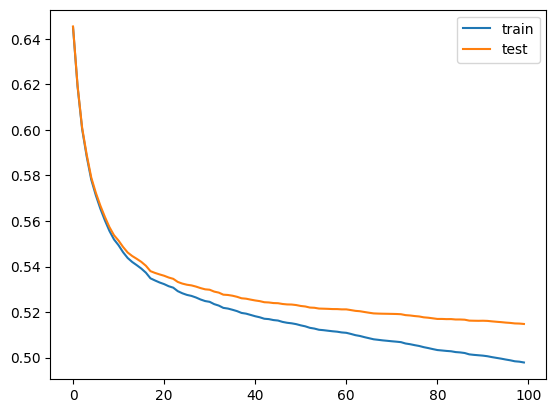

In [39]:
# Plot learning curves
import matplotlib.pyplot as plt
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# display legend
plt.legend()
# render
plt.show()

## Put it all together:

* Use the results from the gridsearch and add an additional parameter n_estimators
        
        n_estimators are the number of trees in the forest. default=100    

*   From the curves above you can see that they are still at a slope when n_estimators is at 100.  In this case it would seem that increasing the number of trees might yield a better result. We know that we achieve 72% when using the default 100 trees and our best results discovered via the grid search is approximately 80%.  Can we do better?

* Start by setting up a new parameters section and use the values discovered earlier.  In addition set n_estimators to 1000 and see if a better result is achieved.

In [40]:
# Set XGBoost parameters
xgb_params = {
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'disable_default_eval_metric':  'true',
    'max_depth':                     8,
    'learning_rate':                 0.1,
    'subsample':                     1,
    'gamma':                         0,
    'reg_lambda':                    10,
    'scale_pos_weight':              1,
    'tree_method':                  'hist', 
    'n_estimators':                  1000,
}

# Train the model
t1_start = perf_counter()  # Time fit function
model_xgb= xgb.XGBClassifier(**xgb_params)
model_xgb.fit(X_train,y_train, eval_metric='logloss', eval_set=evalset, verbose=True)
t1_stop = perf_counter()
print ("It took", t1_stop-t1_start,"seconds to fit.")

[0]	validation_0-logloss:0.67132	validation_1-logloss:0.67162
[1]	validation_0-logloss:0.65471	validation_1-logloss:0.65527
[2]	validation_0-logloss:0.64055	validation_1-logloss:0.64140
[3]	validation_0-logloss:0.62866	validation_1-logloss:0.62969
[4]	validation_0-logloss:0.61819	validation_1-logloss:0.61941
[5]	validation_0-logloss:0.60920	validation_1-logloss:0.61067
[6]	validation_0-logloss:0.60133	validation_1-logloss:0.60298
[7]	validation_0-logloss:0.59431	validation_1-logloss:0.59616
[8]	validation_0-logloss:0.58822	validation_1-logloss:0.59029
[9]	validation_0-logloss:0.58276	validation_1-logloss:0.58502
[10]	validation_0-logloss:0.57807	validation_1-logloss:0.58053
[11]	validation_0-logloss:0.57351	validation_1-logloss:0.57621
[12]	validation_0-logloss:0.56950	validation_1-logloss:0.57247
[13]	validation_0-logloss:0.56583	validation_1-logloss:0.56902
[14]	validation_0-logloss:0.56255	validation_1-logloss:0.56593
[15]	validation_0-logloss:0.55951	validation_1-logloss:0.56309
[1

In [41]:
# Check model accuracy
result_predict_xgb_test = model_xgb.predict(X_test)
acc = np.mean(y_test == result_predict_xgb_test)
print("Model accuracy =",acc)

Model accuracy = 0.7503526170798898


In [42]:
# retrieve performance metrics
results = model_xgb.evals_result()

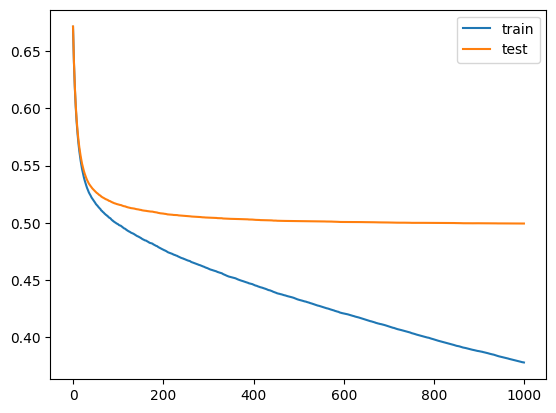

In [43]:
# Plot learning curves
import matplotlib.pyplot as plt
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# display legend
plt.legend()
# render
plt.show()

## So how many trees do we need really?

* It takes awhile to watch 1000 trees get evaluated, a great performance improvement is to use the XGBoost early stopping capability.

* Modify the fit function to stop the training after 10 to 15 rounds of no improvement.  
        
        model_xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evalset, verbose=True)

* Depending on how large a dataset you used this will vary.  There are numerous other optimizations that one can undertake, hopefully this gets you started.



# Summary:

* We covered how to set parameters for XGBoost.
* How to enable Intel's SciKit-Learn features
* How to use CV to identify better hyperparameter options
* How to use a learning curve to estimate the number of trees
* How to use early stopping to optimize training time